In [ ]:
!conda install pytorch torchvision torchaudio pytorch-cuda=11.7 -c pytorch -c nvidia --yes

!git clone https://github.com/facebookresearch/detectron2.git
!pip install -e detectron2
!pip install pytorch-lightning
!pip install plotly
!rm -rf detectron2


Retrieving notices: done
Channels:
 - pytorch
 - nvidia
 - defaults
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /home/vladimir/miniconda3

  added / updated specs:
    - pytorch
    - pytorch-cuda=11.7
    - torchaudio
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2024.12.31 |       h06a4308_0         128 KB
    ------------------------------------------------------------
                                           Total:         128 KB

The following packages will be UPDATED:

  ca-certificates                     2024.11.26-h06a4308_0 --> 2024.12.31-h06a4308_0 



                                                                                
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
fatal: destination path 'detectron2' already exists and is not an empty directo

In [5]:
import cv2
import numpy as np
import detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog
import torch.nn.functional as F
import pytorch_lightning as pl 
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from torchvision import datasets
import torch
from torchmetrics import Metric
import torchmetrics
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import random
import os
from tqdm import tqdm
import math
from copy import deepcopy

### Сегментация изображений (object detection)

#### Настройка конфигурации модели для сегментации

In [2]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3
cfg.MODEL.EVALUATOR_TYPE = 'coco'
cfg.MODEL.DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

#### Для сегментации использую предобученную модель Panoptic FPN R101

In [8]:
predictor = DefaultPredictor(cfg)

In [19]:
def visualize_segments_tomats(image_folder):

    plt.figure(figsize=(24, 10))

    image_files = [f for f in os.listdir(image_folder) if f.endswith(('.jpg'))]

    sample_images = random.sample(image_files, min(8, len(image_files)))


    for i, image_file in enumerate(tqdm(sample_images)):

        image_path = os.path.join(image_folder, image_file)
        image = cv2.imread(image_path)

        outputs = predictor(image)

        v = Visualizer(image[:, :, ::-1], metadata=None, scale=1, instance_mode=ColorMode.IMAGE)
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        rgb_image = out.get_image()[:, :, ::1]  

        plt.subplot(2, 4, i + 1)
        plt.imshow(rgb_image)
        plt.axis('off')
        plt.title(f"{image_file}")

    plt.tight_layout()
    plt.show()


100%|██████████| 8/8 [00:42<00:00,  5.29s/it]


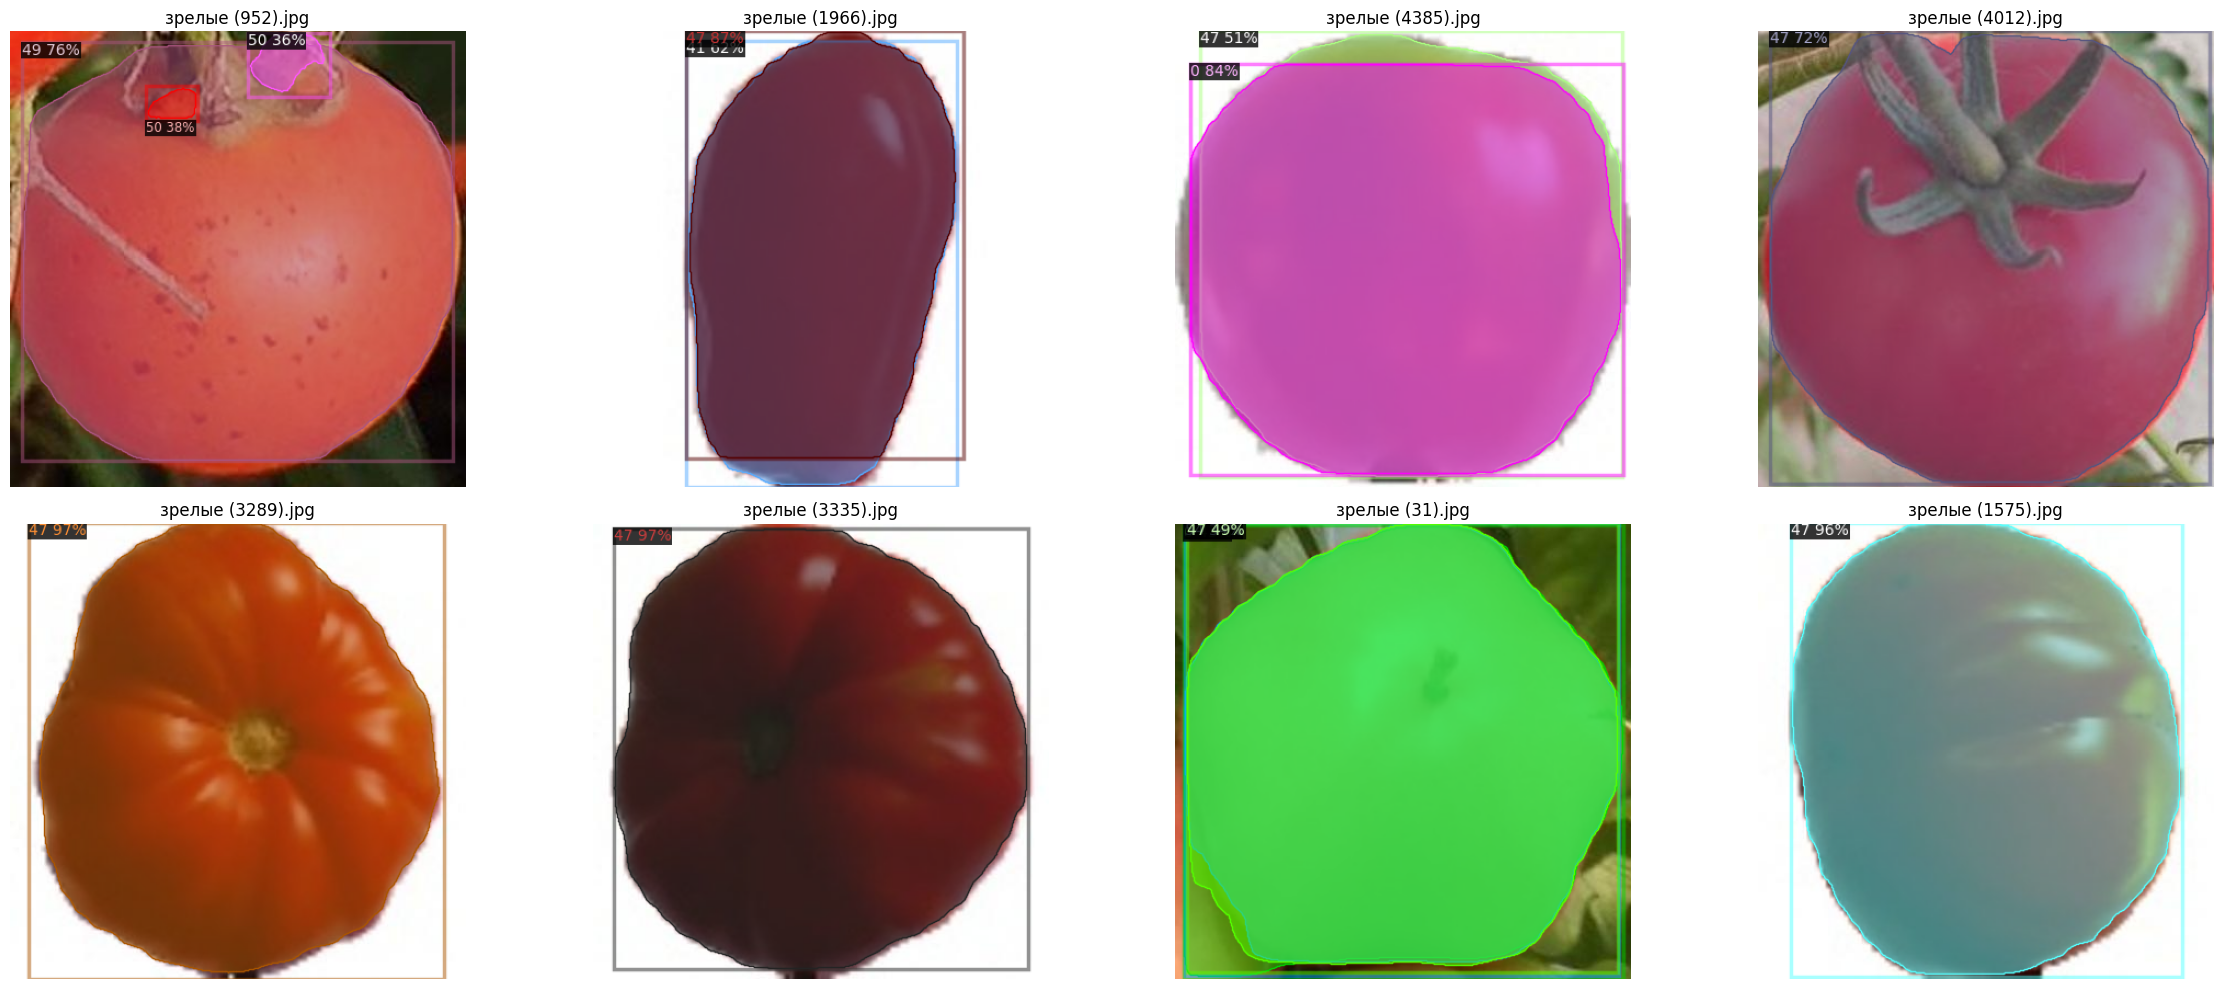

In [23]:
visualize_segments_tomats("data/Зрелый")

100%|██████████| 8/8 [00:40<00:00,  5.09s/it]


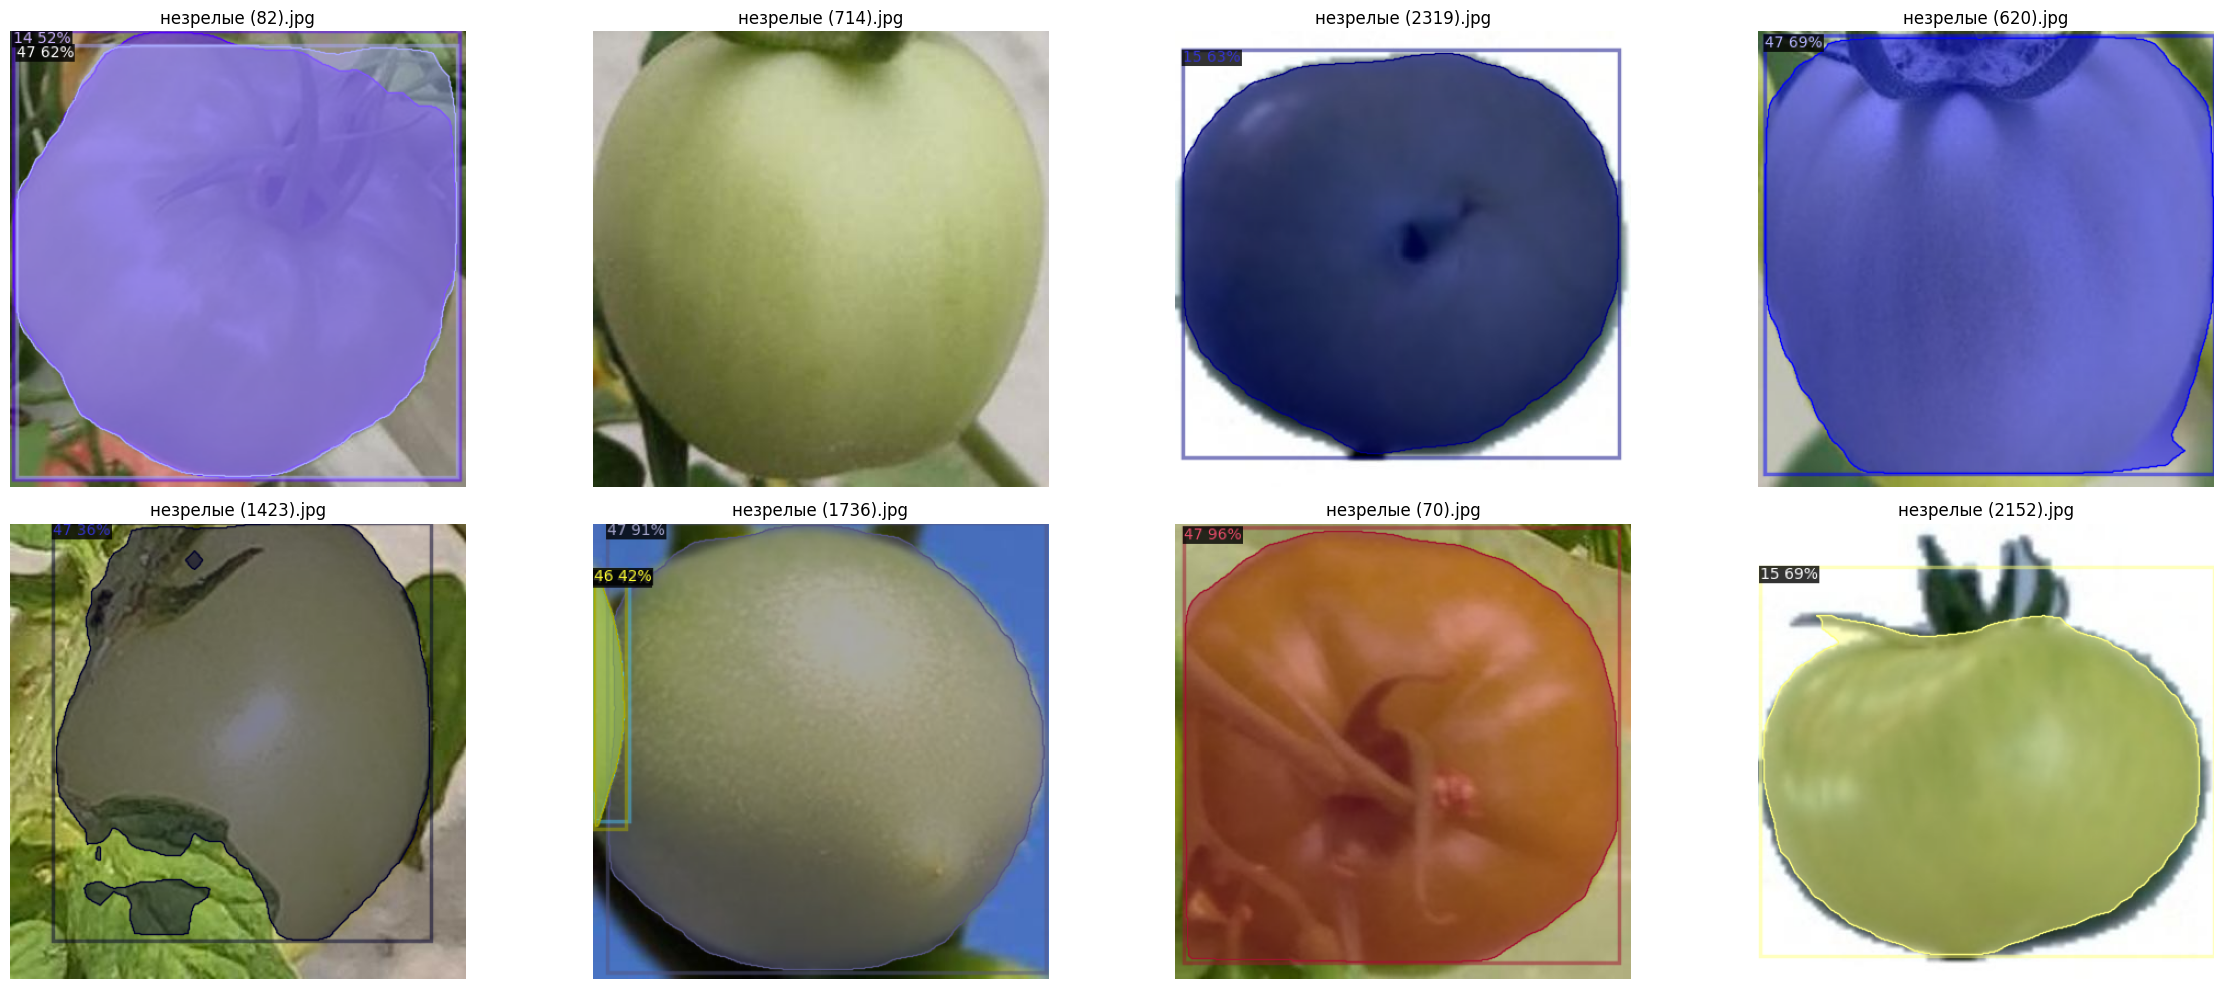

In [21]:
visualize_segments_tomats("data/Незрелый")

100%|██████████| 8/8 [00:52<00:00,  6.59s/it]


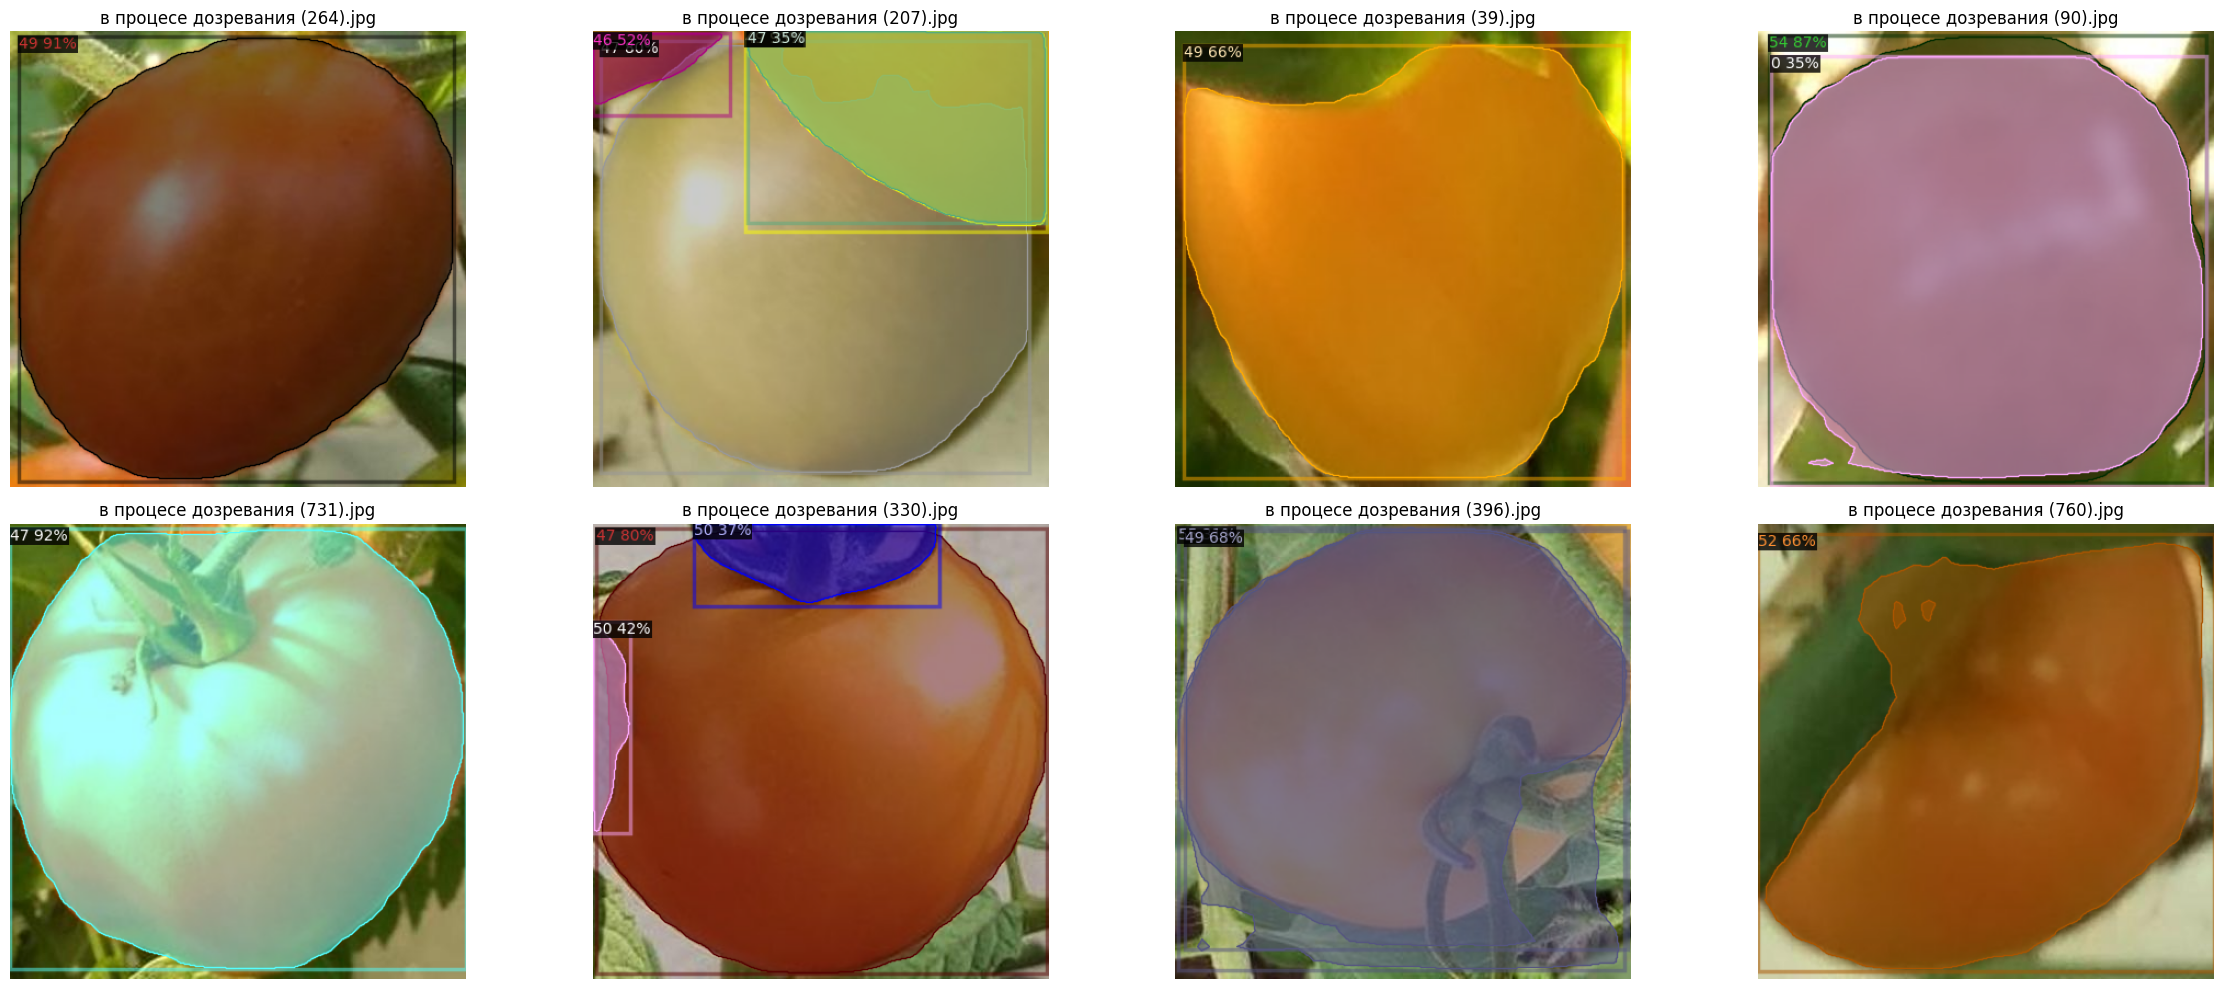

In [22]:
visualize_segments_tomats("data/В процесе созревания")

#### Из результатов видно, что модель способна обнаруживать томаты (кроме одного недозревщего томата (714))

### Классификация изображений

#### Конфигурация модели и обучения

In [150]:
MAX_EPOCHS = 16
MIN_EPOCHS = 1
BATCH_SIZE = 16
IMAGE_SIZE = (128, 128)
accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'
LEARNING_RATE = 1e-5
devices = torch.cuda.device_count() if torch.cuda.is_available() else 1

#### модель

In [127]:
class NN(pl.LightningModule):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 50)
        self.fc2 = nn.Linear(50, num_classes)

        self.accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes)
        self.auc = torchmetrics.AUROC(task='multiclass', num_classes=num_classes)
        self.f1_score = torchmetrics.F1Score(task="multiclass", num_classes=num_classes)

    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    

    def _common_step(self, batch, batch_idx):
        x, y = batch
        x = x.reshape(x.size(0), -1)
        scores = self.forward(x)
        loss = F.cross_entropy(scores, y)
        return loss, scores, y


    def training_step(self, batch, batch_idx):        
        loss, scores, y = self._common_step(batch, batch_idx)
        accuracy = self.accuracy(scores, y)
        auc_score = self.auc(scores, y)
        f1_score = self.f1_score(scores, y)
        self.log_dict(
            {'train_loss': loss, 'train_accuracy': accuracy, 'train_f1_score': f1_score, 'train_auc': auc_score},
            on_step=False,
            on_epoch=True,
            prog_bar=True
        )
        
        return {'loss': loss, "scores": scores, "y": y}
    
    
    def validation_step(self, batch, batch_idx):
        loss, scores, y = self._common_step(batch, batch_idx)
        accuracy = self.accuracy(scores, y)
        auc_score = self.auc(scores, y)
        f1_score = self.f1_score(scores, y)

        to_log = {'val_loss': loss, 'val_accuracy': accuracy, 'val_f1_score': f1_score, 'val_auc': auc_score}
        logs.append(to_log)
        
        self.log_dict(to_log,
                      on_step=False, on_epoch=True, prog_bar=True)
        return loss
    

    def test_step(self, batch, batch_idx):
        loss, scores, y = self._common_step(batch, batch_idx)
        accuracy = self.accuracy(scores, y)
        auc_score = self.auc(scores, y)
        f1_score = self.f1_score(scores, y)
        self.log_dict({'test_loss': loss, 'test_accuracy': accuracy, 'test_f1_score': f1_score, 'test_auc': auc_score})
        return loss
    

    def predict_step(self, batch, batch_idx):
        x, y = batch
        x = x.reshape(x.size(0), -1)
        scores = self.forward(x)
        preds = self.argmax(scores, dim=1)
    

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=LEARNING_RATE)


#### Предобрабтка данных

In [128]:
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
])

entire_dataset = datasets.ImageFolder(root='data', transform=transform)
train_ds, val_ds, test_ds = random_split(entire_dataset, [0.7, 0.1, 0.2])

train_loader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_ds, batch_size=BATCH_SIZE, shuffle=False)


In [129]:
logs = []

#### Обучение

In [130]:
model = NN(input_size=128*128*3, num_classes=3)
trainer = pl.Trainer(accelerator=accelerator, devices=devices, min_epochs=MIN_EPOCHS, max_epochs=MAX_EPOCHS)
trainer.fit(model, train_loader, val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | fc1      | Linear             | 2.5 M  | train
1 | fc2      | Linear             | 153    | train
2 | accuracy | MulticlassAccuracy | 0      | train
3 | auc      | MulticlassAUROC    | 0      | train
4 | f1_score | MulticlassF1Score  | 0      | train
--------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.831     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


/home/vladimir/miniconda3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/vladimir/miniconda3/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/vladimir/miniconda3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 1: 100%|██████████| 339/339 [00:38<00:00,  8.83it/s, v_num=16, val_loss=0.0912, val_accuracy=0.969, val_f1_score=0.969, val_auc=0.886, train_loss=0.136, train_accuracy=0.959, train_f1_score=0.959, train_auc=0.899]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 339/339 [00:38<00:00,  8.82it/s, v_num=16, val_loss=0.0912, val_accuracy=0.969, val_f1_score=0.969, val_auc=0.886, train_loss=0.136, train_accuracy=0.959, train_f1_score=0.959, train_auc=0.899]


#### Результат

In [131]:
trainer.validate(model, val_loader)
trainer.test(model, test_loader)

Validation: |          | 0/? [00:00<?, ?it/s]

Validation DataLoader 0: 100%|██████████| 49/49 [00:07<00:00,  6.78it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.9690322875976562     │
│          val_auc          │    0.8856692314147949     │
│       val_f1_score        │    0.9690322875976562     │
│         val_loss          │    0.09120901674032211    │
└───────────────────────────┴───────────────────────────┘

/home/vladimir/miniconda3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 97/97 [00:13<00:00,  7.34it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9715762138366699     │
│         test_auc          │    0.8607025742530823     │
│       test_f1_score       │    0.9715762138366699     │
│         test_loss         │    0.0956433042883873     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.0956433042883873,
  'test_accuracy': 0.9715762138366699,
  'test_f1_score': 0.9715762138366699,
  'test_auc': 0.8607025742530823}]

In [136]:
logs = pd.DataFrame(logs)

In [142]:
val_loss = logs.val_loss.apply(lambda el: el.item()).tolist()
val_accuracy = logs.val_accuracy.apply(lambda el: el.item()).tolist()
val_f1_score = logs.val_f1_score.apply(lambda el: el.item()).tolist()
val_auc = logs.val_auc.apply(lambda el: el.item()).tolist()

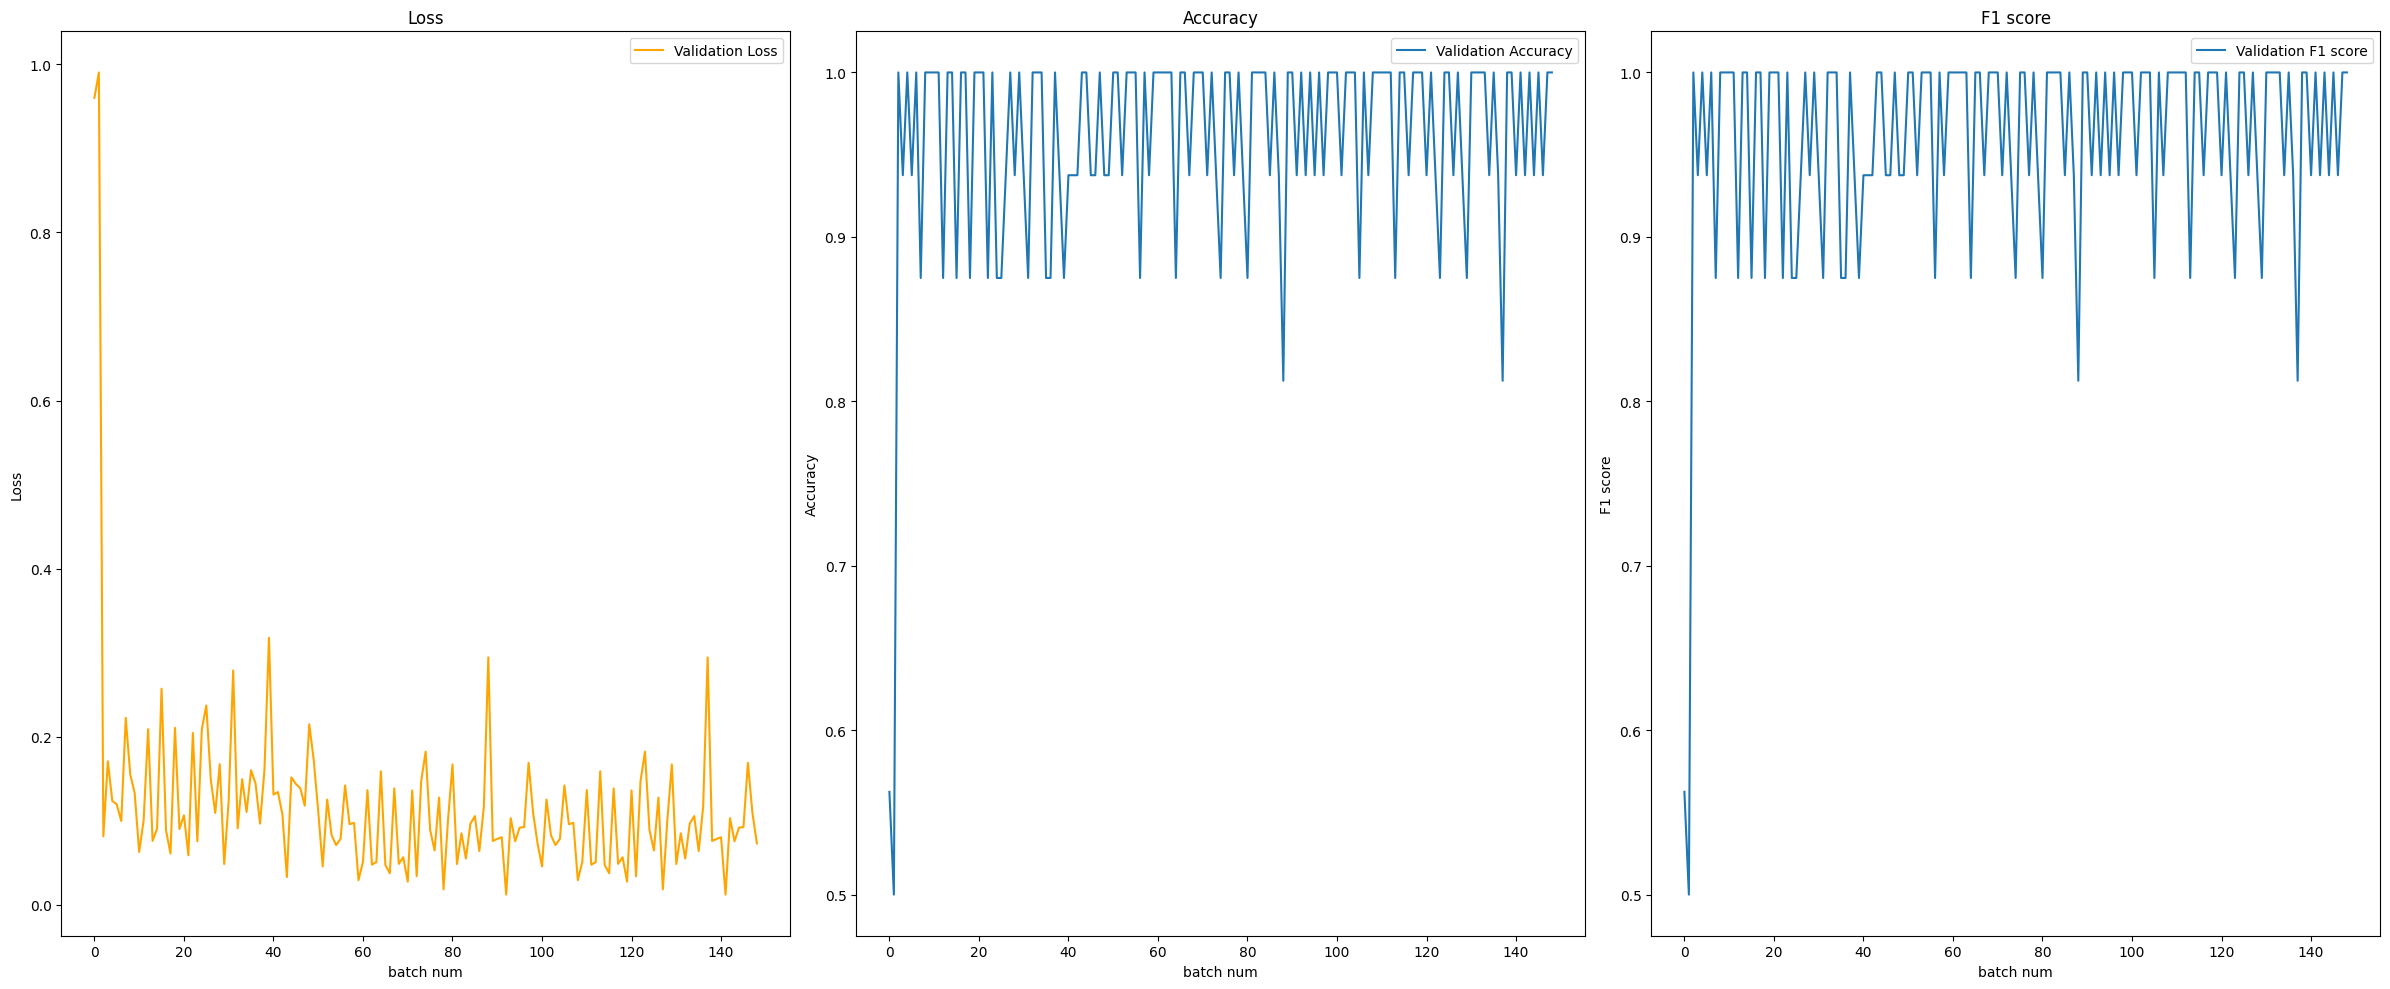

In [149]:
plt.figure(figsize=(24, 10))

plt.subplot(1, 3, 1)
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.title('Loss')
plt.xlabel('batch num')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('batch num')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 3, 3)
plt.plot(val_f1_score, label='Validation F1 score')
plt.title('F1 score')
plt.xlabel('batch num')
plt.ylabel('F1 score')
plt.legend()


plt.tight_layout()
plt.show()


### Углы изходя из координат

In [23]:
def calculate_angles(x, y, L1, L2, L3, L4):
    theta1 = math.acos(((x + L4)**2 + (y - L3)**2 + L1**2 - L2**2) / (2 * L1 * math.sqrt((x + L4)**2 + (y - L3)**2))) \
             + math.atan2(y - L3, x + L4)
    theta2 = math.acos((-((x + L4)**2 + (y - L3)**2) - L1**2 + L2**2) / (2 * L1 * L2))
    theta3 = math.pi - theta1 + theta2
    theta4 = math.pi / 2
    return {'theta1': theta1, 'theta2': theta2, 'theta3': theta3, 'theta4': theta4}


def get_object_centers_and_corners(image_path):
    image = cv2.imread(image_path)
    
    outputs = predictor(image)
    
    instances = outputs["instances"]
    boxes = instances.pred_boxes.tensor.cpu().numpy()
    
    centers = []
    corners = []
    
    for box in boxes:
        x1, y1, x2, y2 = box
        
        center_x = (x1 + x2) / 2
        center_y = (y1 + y2) / 2
        centers.append(({'x': float(center_x), 'y': float(center_y)}))
        
        corners.append(({'x1': float(x1), 'y1': float(y1), 'x2': float(x2), 'y2': float(y2)}))

    return {'centers': centers, 'corners': corners}



def get_angles_from_image(image_path, L1, L2, L3, L4):
    obj_coords = get_object_centers_and_corners(image_path)
    angles =  [calculate_angles(center['x'], center['y'], L1, L2, L3, L4) for center in obj_coords['centers']]
    coords = deepcopy(obj_coords)

    coords['angles'] = angles

    return coords


In [24]:
image_path = 'data/Незрелый/незрелые (30).jpg'
L1 = 2500
L2 = 2500
L3 = 2500
L4 = 900

get_angles_from_image(image_path, L1, L2, L3, L4)

{'centers': [{'x': 203.5872039794922, 'y': 202.86485290527344},
  {'x': 206.7910614013672, 'y': 204.43789672851562}],
 'corners': [{'x1': 0.0,
   'y1': 5.285867691040039,
   'x2': 407.1744079589844,
   'y2': 400.44384765625},
  {'x1': 7.879027843475342,
   'y1': 12.215302467346191,
   'x2': 405.7030944824219,
   'y2': 396.6604919433594}],
 'angles': [{'theta1': -0.08697029375373533,
   'theta2': 2.117154201657583,
   'theta3': 5.345717149001111,
   'theta4': 1.5707963267948966},
  {'theta1': -0.08556329553777853,
   'theta2': 2.1171408334102466,
   'theta3': 5.3442967825378185,
   'theta4': 1.5707963267948966}]}